In [1]:
import numpy as np  
from support_functions import *
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model

Using TensorFlow backend.


## Parameters

In [2]:
anomaly_digit = 2 # Set digit 2 as our anomaly
n_components=30 # 30 components in the encoded matrix
k = 50 # Define the k parameter for the precision at k

## Read Data

In [3]:
data_path = 'data/input_data/'
# Read image matrix (n*m), labels (vector of m), and image size
imgs_train, imgs_test, labels_train, labels_test, height, width = read_process_data(data_path, anomaly_digit)
# The length of one image vector
img_size = height*width 

### Load the Saved Models
#### Autoencoder Model

In [4]:
# Generate and Compile a Deep Autoencoder
autoencoder, encoder = compile_autoencoder(img_size) 
autoencoder = load_model('model_autoencoder.h5') # Load the saved model

#### Encoder Model
Encoder is the first half of the autoencoder model and it is not compiled; thus, we retrieve the encoder model based on the autoencoder one. 

In [5]:
weights_encoder = autoencoder.get_weights()[0:4] # The first half of the autoencoder model is an encoder model
encoder.set_weights(weights_encoder) # Set weights

In [6]:
print(encoder.summary())
print("\n The output shape of the encoder model: ")
print(encoder.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1950      
Total params: 141,406
Trainable params: 141,406
Non-trainable params: 0
_________________________________________________________________
None

 The output shape of the encoder model: 
(None, 30)


### Visualize the Reconstructed Image

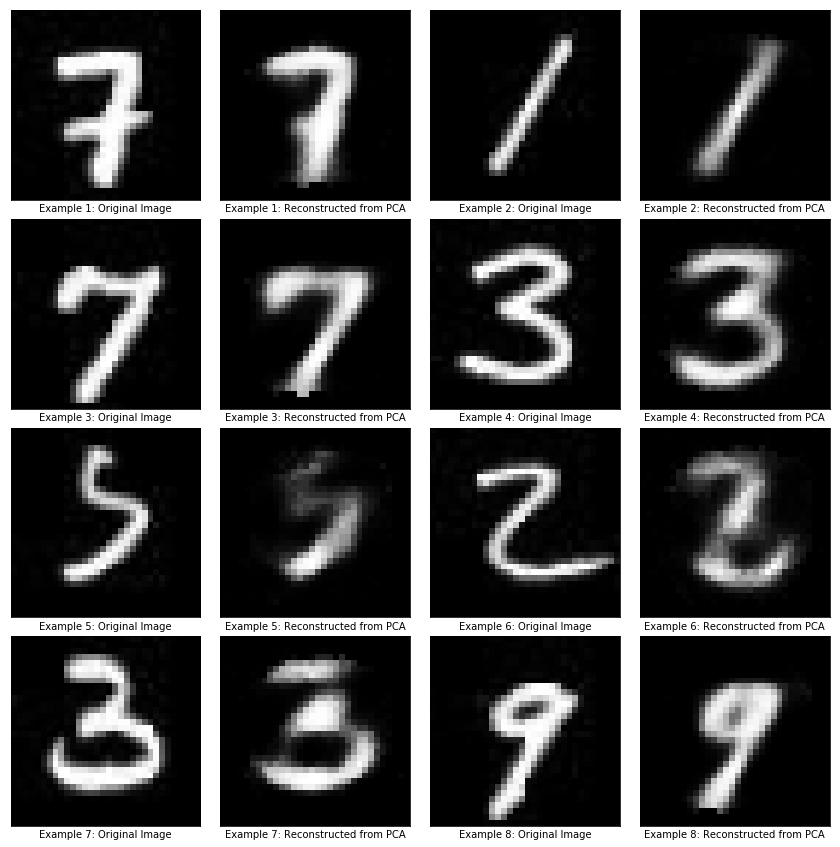

In [7]:
imgs = imgs_train.astype('float32') / 255. # Normalize the Data
# Load into the model and get the processed output
imgs_reconst = autoencoder.predict(imgs)

# Plot the original images and their reconstructed version for comparison
plot_compare_after_reconst(imgs_reconst,imgs_train,height,width)

## Implement the Anomaly Detection with the Gaussian Distribution

### Encode the images in the Training Set and the Testing Set

In [8]:
# Normalize the Data
x_train = imgs_train.astype('float32') / 255. # Normalize the Data
x_test = imgs_test.astype('float32') / 255. # Normalize the Data

encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

### Visualize the Distribution of Data Points in the encoded matrix

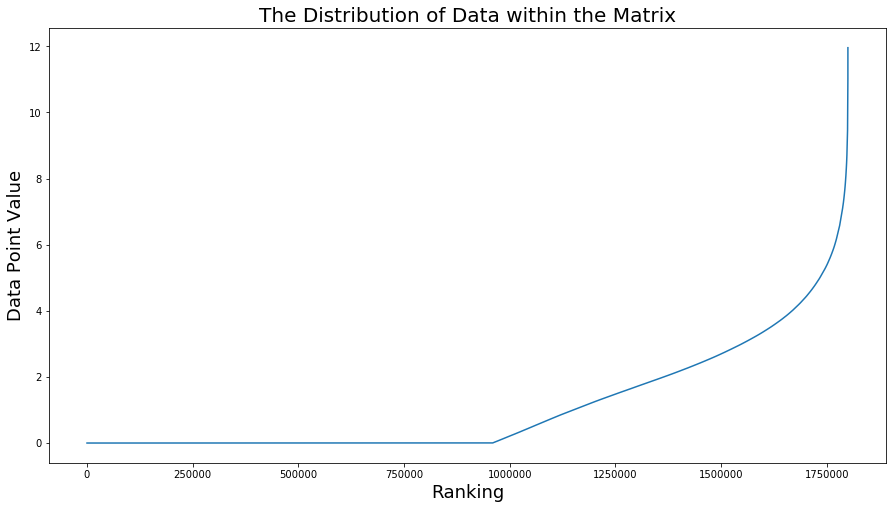

In [9]:
plot_matrix_data(encoded_train)

### Fit a Gaussian Distribution Model with the Training Set

In [10]:
# Get Gaussian Distribution Model for the Validation Data
# Note: fit_multivariate_gaussian() is my own coded function
dist_train = fit_multivariate_gaussian(encoded_train)

LinAlgError: singular matrix

### Visualize the Distribution of the Anomaly vs. Normal Set through Scatterplot

In [ ]:
# Get Probability of being Anomaly vs. being Normal
p_train = dist_train.pdf(encoded_train)   # Probability of Being Normal
# Plot the Probability with labels
plot_scatter_with_labels(p_train, labels_train,'Gaussian Probability')


In [ ]:

# Train the Anomaly Detector
threshold_gaussian  = select_threshold_probability(p_train, labels_train,k,to_print = True)

### Apply to the Testing Data

In [ ]:
# Find the euclidean distance between the reconstructed dataset and the original ()
p_test = dist_train.pdf(encoded_test)   # Probability of Being Normal

# Sort the Images and Labels based on the Probability
rank_test = np.argsort(p_test) # Sort from the Smallest to the Largest
p_test_ranked = p_test[rank_test] # Sort the distance
labels_test_ranked = labels_test[rank_test] # Rank Labels

# Give Predictions
preds = np.zeros(labels_test.shape) # Initialization
preds[p_test_ranked < threshold_gaussian] = 1 # If the probability is smaller than the threshold, marked as anomaly

# Evaluate the Detector with Testing Data
eval_with_test(preds, labels_test_ranked, k = k)